In [2]:
import math
import numpy as np
from plotnine import *
import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

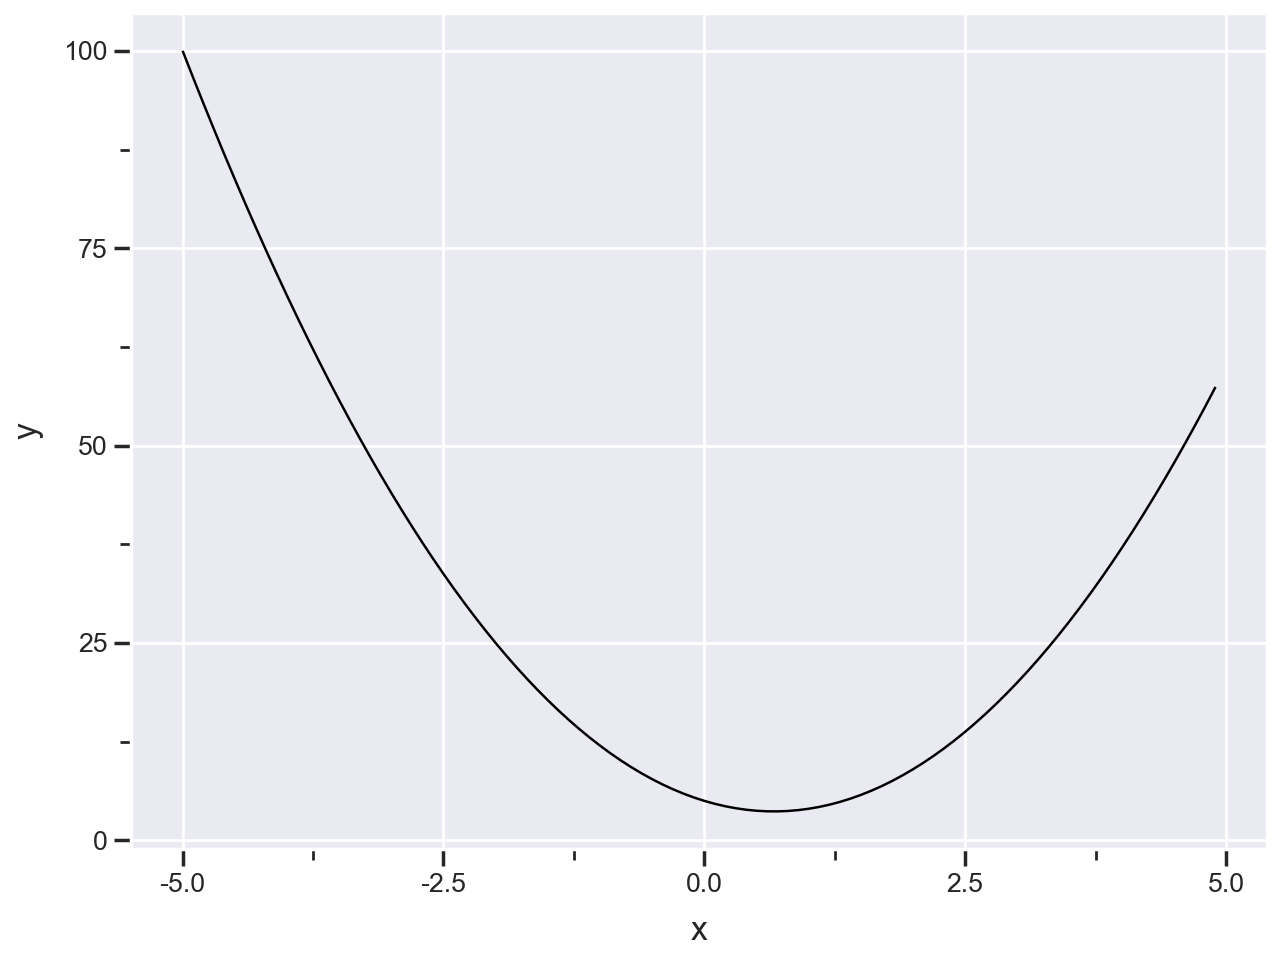

In [4]:
xs = np.arange(-5, 5, 0.1)
ys = [f(x) for x in xs]
(pl.DataFrame({'x': xs, 'y': ys})
    >> ggplot(aes('x', 'y')) + geom_line() + theme_seaborn()
)

* __add__ , __repr__ are magic methods
* python internally calls `a.__add__(b)` when we do `a + b` and a magic `__add__` method is defined
* we need an expression graph: what values produce what other values?
* to store the children meaningfully, we also need to know the operation

In [181]:

class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        # is a tuple first for convenience, but maintained as a set in the class for efficiency
        self._prev = set(_children) 
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers"
        out = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * self.data ** (other-1) * out.grad
        out._backward = _backward
        
        return out
                
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad 
        out._backward = _backward
        return out
        
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child) 
                topo.append(v) # only adds itself once the children have been added
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [182]:

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

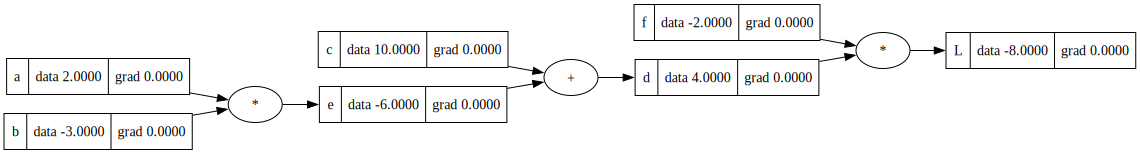

In [183]:
draw_dot(L)

### a real neuron

In [184]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

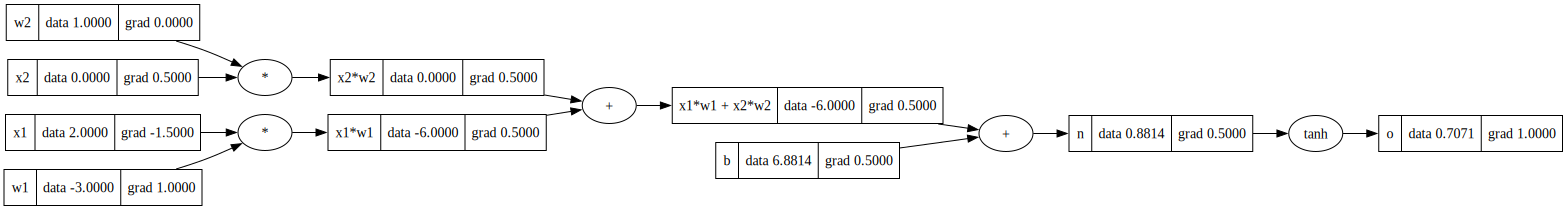

In [185]:
draw_dot(o)

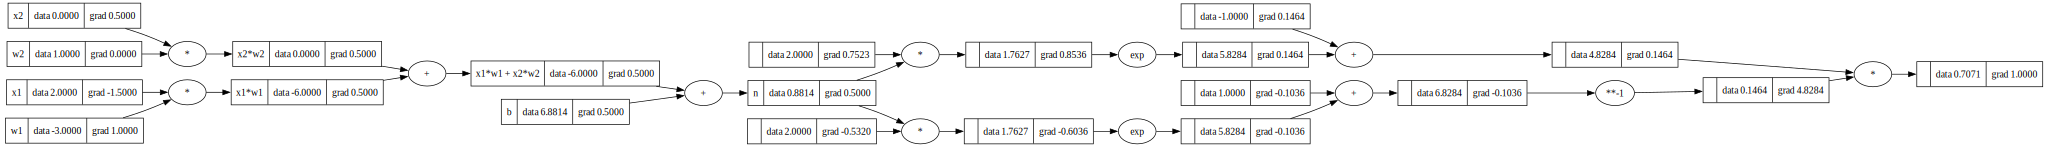

In [187]:
draw_dot(o)

In [186]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#o = n.tanh(); o.label = 'o'
o = ((2*n).exp() - 1) / ((2*n).exp() + 1); label = o
o.backward()

In [ ]:
import torch

# x1,x2, w1, w2 are leaf nodes and therefore nothing we'd usually like the gradients for
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)


print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w2', w2.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w2 0.0


### implement the MLP myself

In [432]:
import random

In [472]:
# input
x = [[3.0, 0.1, 4.0],
     [1.0, 10.0, 7.0],
     [3.0, 1.0, 3.0],
     [4.0, 4.0, 7.0]]

y = [1.0, -1.0, 1.0, -1.0]

In [628]:
class Neuron():
    
    def __init__(self, nin: int):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        act = sum([wi * xi for wi, xi in zip(self.w, x)]) + self.b
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
    def __repr__(self):
        return f"Neuron(nin={len(self.w)})"
    

class Layer():
    
    def __init__(self, nin: int, nout: int):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        out = [neuron(x) for neuron in self.neurons]
        return out[0] if len(out)==1 else out
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
    def __repr__(self):
        return f"Layer(neurons={len(self.neurons)})"
    
    
class MLP():
    
    def __init__(self, nin: int, nouts: list):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
    
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def __repr__(self):
        layer_sizes = [len(layer.neurons) for layer in self.layers]
        arch = " → ".join(map(str, layer_sizes))
        return f"MLP({arch})"

In [649]:
# model
nn = MLP(3, [3, 5, 5, 1])
# loss
def mse(pred, gtruth):
    return sum([(x-y)**2 for x, y in zip(pred, gtruth)])


In [ ]:
# train loop
for i in range(50):
    
    # forward pass
    preds = [nn(xi) for xi in x]
    loss = mse(preds, y)
    
    # backward pass
    # zero gradients
    for p in nn.parameters():
        p.grad = 0.0
    loss.backward()
    
    # gradients
    for p in nn.parameters():
        p.data += -p.grad * 0.1
    
    print(i, round(loss.data,2),[round(pred.data,2) for pred in preds])    

0 2.54 [0.35, -0.94, 0.33, 0.29]
1 2.34 [0.38, -0.94, 0.34, 0.23]
2 1.68 [0.44, -0.95, 0.39, -0.0]
3 0.63 [0.51, -0.96, 0.46, -0.69]
4 0.22 [0.8, -0.97, 0.79, -0.63]
5 0.1 [0.8, -0.98, 0.78, -0.87]
6 0.07 [0.84, -0.98, 0.83, -0.87]
7 0.06 [0.86, -0.98, 0.85, -0.88]
8 0.05 [0.87, -0.98, 0.86, -0.89]
9 0.04 [0.88, -0.98, 0.88, -0.89]
10 0.04 [0.89, -0.98, 0.88, -0.9]
11 0.03 [0.9, -0.98, 0.89, -0.9]
12 0.03 [0.9, -0.98, 0.9, -0.91]
13 0.03 [0.91, -0.98, 0.9, -0.91]
14 0.02 [0.91, -0.98, 0.91, -0.92]
15 0.02 [0.92, -0.98, 0.91, -0.92]
16 0.02 [0.92, -0.98, 0.91, -0.92]
17 0.02 [0.92, -0.98, 0.92, -0.93]
18 0.02 [0.93, -0.98, 0.92, -0.93]
19 0.02 [0.93, -0.98, 0.92, -0.93]
20 0.02 [0.93, -0.98, 0.92, -0.93]
21 0.01 [0.93, -0.98, 0.93, -0.93]
22 0.01 [0.93, -0.98, 0.93, -0.93]
23 0.01 [0.94, -0.98, 0.93, -0.94]
24 0.01 [0.94, -0.99, 0.93, -0.94]
25 0.01 [0.94, -0.99, 0.93, -0.94]
26 0.01 [0.94, -0.99, 0.94, -0.94]
27 0.01 [0.94, -0.99, 0.94, -0.94]
28 0.01 [0.94, -0.99, 0.94, -0.94]
29 0.01

In [213]:
random.uniform(-1, 1)

0.9403150700253231

In [382]:
import random

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = [p for neuron in self.neurons for p in neuron.parameters()]
        return params

class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = [p for layer in self.layers for p in layer.parameters()]
        return params
    

In [429]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)
        

Value(data=0.8513068487259103)

In [430]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [431]:
# forward pass
for k in range(20):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
        
    # update
    # gradient vector points in direction of increasing the loss, so we have to -
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    print(k, loss.data)

0 7.5233470008886
1 7.2942889759731315
2 6.7642875593529075
3 5.018507842177153
4 2.079776704481752
5 0.8861690538841113
6 0.28664537434545034
7 0.20859038962274726
8 0.16469933293112746
9 0.13599521896603936
10 0.11572625512064932
11 0.10065644968572261
12 0.0890192401149429
13 0.07976618135301661
14 0.0722355993061624
15 0.06598942131812405
16 0.060726186541573676
17 0.05623171516341843
18 0.05234969759627299
19 0.04896341458278618


In [427]:
ypred

[Value(data=0.9999999326356308),
 Value(data=-1.0),
 Value(data=-1.0),
 Value(data=0.9999999325893372)]